## **Machine Learning for Physics and Astronomy**

BSc program in Physics and Astronomy (Honours track), University van Amsterdam and Vrije Universiteit Amsterdam.

**Academic year 2021-2022**. 

Course instructors:

* Dr. Juan Rojo ([j.rojo@vu.nl](mailto:j.rojo@vu.nl))

* Dr. Tommaso Giani ([tgiani@nikhef.nl](mailto:tgiani@nikhef.nl))

* Mr. Ryan van Mastrigt ([r.vanmastrigt@uva.nl](mailto:r.vanmastrigt@uva.nl))
    
Lecture notes, tutorial notebooks, and other learning materials of the course can be found in its [GitHub repository](https://github.com/LHCfitNikhef/ML4PA)

## Tutorial 1: Fitting versus predicting in Machine Learning

---


In [2]:
#This is Python Notebook to walk through polynomial regression examples
#We will use these imports

import numpy as np
%matplotlib inline


from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt, rcParams

## Source

https://github.com/Emergent-Behaviors-in-Biology/mlreview_notebooks


## Overview 

In this notebook, we will get our hands dirty trying to gain intuition about why machine learning is difficult. 

Our task is going to be a simple one, **fitting data with polynomials of different order**. Formally, this goes under the name of polynomial regression. Here we will do a series of exercises that are intended to give the reader intuition about the major challenges that any machine learning algorithm faces.

## Learning Goal

We will explore how our ability to predict depends on the following three things:

- The number of data points we have
- The "noise" in the data
- Our knowledge about relevant features 

The goal is to build intuition about why prediction is difficult and discuss general strategies for overcoming these difficulties.

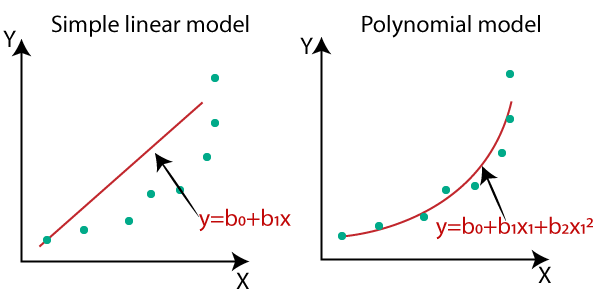

Specifically, we want to understand better why it is that the right figure provides a better prediction than the left one does.

<sub>Figure source: https://www.javatpoint.com/machine-learning-polynomial-regression<sub>

## The Prediction Problem

Consider a probabilistic process that gives rise to labeled data $(x,y)$. The data is generated by drawing samples from the equation

$$
    y_i= f(x_i) + \eta_i,
$$

where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelated noise variable such that the expected value of $\eta_i$ is equal to zero,

$$
\langle \eta_i \rangle=0. \\
$$

Uncorrelated noise means that the covariance of $\eta_i$ and $\eta_j$ is equal to $\sigma$ if and only if i = j,

$$
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma.
$$



We will refer to the $f(x_i)$ as the **true features** used to generate the data, which is the actual function that we are trying to predict. 

To make this prediction, we will consider a family of functions $g_\alpha(x;\theta_\alpha)$ that depend on some parameters $\theta_\alpha$. These functions respresent the **model class** that we are using to try to model the data and make predictions. The $g_\alpha(x;\theta_\alpha)$ encode the class of **features** we are using to represent the data.

The concept of machine learning works by separating the data into two segments. First we try to 'learn' the parameters $\boldsymbol{\theta}$,by fitting our models on a **training data set** and then secondly we test the effectiveness of this fitted model on a <i>different</i> dataset, the **test data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen. As we will see below, models that give the best fit to the training data do not necessarily make the best predictions on the test data. This will be a running theme that we will encounter repeatedly in machine learning.  

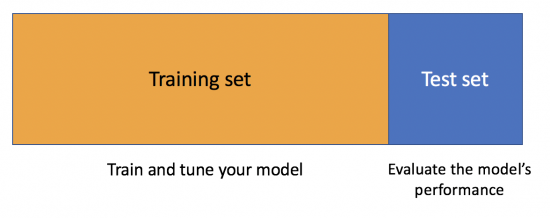

<sub>Figure source: https://docs.splunk.com/Documentation/ITSI/4.5.0/SI/TrainModel<sub>
    
Let's start with generating a function that will create such data sets.

# Question 1a.1) Complete the code to generate true features and the data set as explained here before. Play around with the settings. To show that you have succeeded we want you to hand in a plot of the settings as defined below (xmin = 0., xmax = 1., N = 100, sigma = .1). 

In [2]:
# The parameters needed to create a train/test set are the intervals over which xi is drawn, 
# the number of samples N and the variance of the Noise sigma

def data_set(xmin = 0., xmax = 1., N = 100, sigma = .1, visualization = False):
    # Draw N integers ranging from xmin to xmax
    x = np.linspace(xmin,xmax,N)

    # Draw Gaussian random noise
    s = sigma*np.random.randn(N)

    #""""" Insert code here""""
    
    
    # For clarity of the way the data is constructed we can plot the segments that make up data of y
    if visualization:
        plt.plot(x, fx, 'g', label = 'True features')
        plt.plot(x, s, label = 'Noise')
        plt.plot(x, y, label = 'Generated data')
        plt.legend()
        filename="Data_linear.pdf"
        plt.savefig(filename)
        plt.show()
        
        # Optional: Tenth Order data

#         fx = 2*x - 10*x**5 + 15*x**10
#         y = fx + s
#         plt.plot(x, fx, 'g', label = 'True features')
#         plt.plot(x, s, label = 'Noise')
#         plt.plot(x, y, label = 'Generated data')
#         plt.legend()
#         filename="Data_10th_order.pdf"
#         plt.savefig(filename)
#         plt.show()

    return x, y


# data_set(visualization = True)

### To summarize our goal: we want to predict the data in our the Test Set by feeding the generated data in the Training Set to our (Machine Learning) model.

For the remainder of this notebook, we will focus on polynomial regression. Our task is to model the Generated data with polynomials and make predictions about the new data that we have not seen.
We will consider two qualitatively distinct situations: 
<ul>
<li> In the first case, the process that generates the underlying data is in the model class we are using to make predictions. For polynomial regression, this means that the functions $f(x_i)$ are themselves polynomials.
<li>In the second case, our data lies outside our model class. In the case of polynomial regression, this could correspond to the case where the $f(x_i)$ is a 10-th order polynomial but $g_\alpha(x;\theta_\alpha)$ are polynomials of order 1 or 3.
</ul>

In the exercises and discussion we consider 3 model classes:
<ul>
<li> the case where the $g_\alpha(x;\theta_\alpha)$ are all polynomials up to order 1 (linear models),
<li> the case where the $g_\alpha(x;\theta_\alpha)$ are all polynomials up to order 3,
<li> the case where the $g_\alpha(x;\theta_\alpha)$ are all polynomials up to order 10.
</ul>

## Scoring performance of prediction

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

# Question 1a.2) Write a function that contains this performance measure. What answer should we expect from the following input MSE?

In [3]:
#compute the MSE from two numpy arrays ypredicted and ytrue

ypred = np.array([1,2,3,4])
ytr = np.array([1.05, 1.95, 2.9, 4.5])

def MSE(ypredicted, ytrue):
    
    #""""" Insert code here""""
    
    return
    
MSE(ypred, ytr)

## Fitting vs. predicting when the data is in the model class


We start by considering the case:
$$
f(x)=2x.
$$
Then the data is clearly generated by a model that is contained within all three model classes we are using to make predictions (linear models, third order polynomials, and tenth order polynomials). 



Next, we write a function that fits the data that we have generated to a polynomial function of the order that we can assign ourselves

In [31]:
def fit_data(x, y, order):
    
    # Polynomial Regression of the order that we assigned
    poly = PolynomialFeatures(degree=order)
    
    # Note: sklearn requires a design matrix of shape (N_train, N_features). Thus we reshape x to (N_train, 1):
    X = poly.fit_transform(x[:,np.newaxis])
    
    # Generate the model, which is a linear regression object
    clf = linear_model.LinearRegression()
    
    # Train the model using the training set
    clf.fit(X,y)
    
    return X, clf


# Training the models:

Run the code for the following cases:
<ul> 
<li> For $f(x)=2x$, $N_{\mathrm{train}}=10$ and $\sigma=0$ (noiseless case), train the three classes of models (linear, third-order polynomial, and tenth order polynomial) for a training set when $x_i  \in [0,1]$. Look at difference between the three model fits, and decide which one you think is the best. <li>Repeat the exercises above for $f(x)=2x$, $N_{\mathrm{train}}=100$, and $\sigma=1$. What changes?

# Question 1a.3) Generate a plot that shows the relation between N_train the predictive performance on the training set (MSE). Also do this for the other training data parameter sigma_train, and compare the two plots.

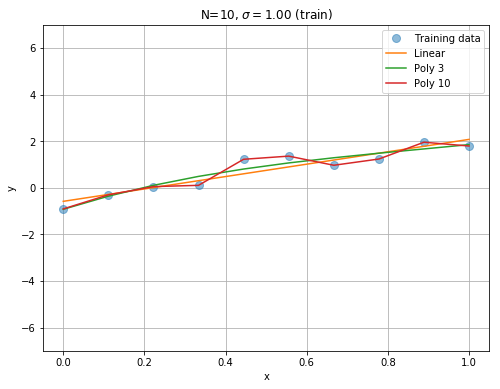

Evaluating the goodness of the models:
First order polynomial model (linear): 0.0976971133924
Third order polynomial model: 0.0667428527002
Tenth order polynomial model: 7.62958453268e-23


In [108]:
N_train = 10
sigma_train = 1

xtrain, ytrain = data_set(N = N_train, sigma = sigma_train)

fig = plt.figure(figsize=(8, 6))

p1 = plt.plot(xtrain, ytrain, "o", ms=8, alpha=0.5, label='Training data')

# fit training data to a first order polynomial
Xtrain, clf1model = fit_data(xtrain, ytrain, 1)
# Use fitted 1st order polynomial model to predict the y value of the samples in the training set\
linear_plot = plt.plot(xtrain, clf1model.predict(Xtrain), label='Linear')

# fit training data to a third order polynomial
X3, clf3model = fit_data(xtrain, ytrain, 3)
# Use fitted 3rd order polynomial model to predict the y value of the samples in the training set\
poly3_plot=plt.plot(xtrain, clf3model.predict(X3), label='Poly 3')

# fit x to a tentraining datah order polynomial
X10, clf10model = fit_data(xtrain, ytrain, 10)
# Use fitted 10th order polynomial model to predict the y value of the samples in the training set\
poly10_plot=plt.plot(xtrain, clf10model.predict(X10), label='Poly 10')

plt.legend(loc='best')
plt.ylim([-7,7])
plt.xlabel("x")
plt.ylabel("y")
Title="N=%i, $\sigma=%.2f$"%(N_train, sigma_train)
plt.title(Title+" (train)")


# Linear Filename
filename_train="train-linear_N=%i_noise=%.2f.pdf"%(N_train, sigma_train)

# # Tenth Order Filename
# #filename_train="train-o10_N=%i_noise=%.2f.pdf"%(N_train, sigma_train)

# # Saving figure and showing results
# plt.savefig(filename_train)
plt.grid()
plt.show()

print('Evaluating the goodness of the models:')
print('First order polynomial model (linear): {}'.format(MSE(clf1model.predict(Xtrain), ytrain)))
print('Third order polynomial model: {}'.format(MSE(clf3model.predict(X3), ytrain)))
print('Tenth order polynomial model: {}'.format(MSE(clf10model.predict(X10), ytrain)))

# Testing the fitted models

Now we generate data in an x interval [0, max_x], which is outside of the interval that we trained our model on [0,1]. We would like to see how if the model that we fitted using our training data, performs the same when predicting this new test data set. What do you expect? You can play around with the variables N_test, sigma_test and max_x, and compare the outcome with the previous cell that used only training data.

# Question 1a.4) Generate similar plots as in the previous question, but now using the three test data parameters (N_train, sigma_train, max_x).

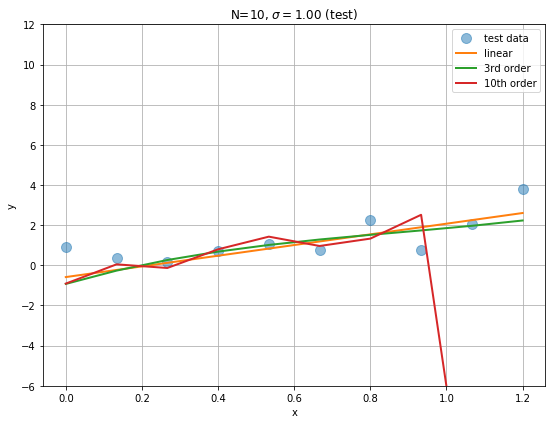

In [110]:
# Number of test data
N_test=10
sigma_test=sigma_train

# Generate random grid points (x) in the interval [0, max_x]:
# Note some points will be drawn outside the training interval
max_x=1.2

# Generate Test Data
xtest, ytest = data_set(xmax = max_x, N = N_test, sigma = sigma_test)

Xtest = fit_data(xtest, ytest, 1)[0]
X3test = fit_data(xtest, ytest, 3)[0]
X10test = fit_data(xtest, ytest, 10)[0]

############## PLOTTING RESULTS ##########

fig = plt.figure(figsize=(8, 6))

p1=plt.plot(xtest, ytest, 'o', ms=10, alpha=0.5, label='test data')
p2=plt.plot(xtest,clf1model.predict(Xtest), lw=2, label='linear')
p3=plt.plot(xtest,clf3model.predict(X3test), lw=2, label='3rd order')
p10=plt.plot(xtest,clf10model.predict(X10test), lw=2, label='10th order')


plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
Title="N=%i, $\sigma=%.2f$"%(N_test,sigma_test)
plt.title(Title+" (test)")
plt.tight_layout()
plt.ylim((-6,12))

# Linear Filename
filename_test="pred-linear_N=%i_noise=%.2f.pdf"%(N_test, sigma_test)

# Tenth Order Filename
#filename_test=Title+"pred-o10.pdf"

# Saving figure and showing results
plt.savefig(filename_test)
plt.grid()
plt.show()

# Question 1a.5) Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well on the test set.